In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nsta.core import estimate_jac, estimate_stability_using_particle
plt.rcParams.update({'font.size': 15})

Let's look at the simplest case possible. We'll estimate the stability of a linear, autonomous RNN: $\mathbf{x}_{t+1} = \mathbf{W}\mathbf{x}_{t}$. Here $\mathbf{x} \in \mathbb{R}^n$ and $\mathbf{W} \in \mathbb{R}^{n \times n}$.

In this case the stability of the RNN is purely determined by the eigenvalues of $\mathbf{W}$ (see pg 21 of Boyd lecture notes for a refresher: https://stanford.edu/class/ee363/lectures/lq-lyap.pdf). 

Specifically, the RNN will be stable when the eigenvalues of $\mathbf{W}$ are inside the unit circle of the complex plane.

In [2]:
def linear_vRNN_update(x,W):
    #update for linear RNN
    return W @ x

def linear_vRNN_jac(x, W):    
    #jacobian of linear RNN
    return W
    
def run_random_vRNN_sim(n,g,T,p):
    #run an n dimensional linear RNN for T timesteps, starting from p different initial conditions.

    #n: number of neurons
    
    #g: chaos dial

    #T: length of sim

    #p: number of trials

    W = np.random.normal(0,g/np.sqrt(n),(n,n))    
    
    xsAllTrials = []
    JsAllTrials = []

    for trial in range(p):

        x = np.random.normal(0,1,n)        
        xsOneTrial = []
        JsOneTrial = []
        for time in range(T):

            x = linear_vRNN_update(x,W)
            xsOneTrial.append(x)
            JsOneTrial.append(linear_vRNN_jac(x, W))

        xsAllTrials.append(xsOneTrial)
        JsAllTrials.append(JsOneTrial)
    
    xsAllTrials = np.stack(xsAllTrials)
    JsAllTrials = np.stack(JsAllTrials)

    

    return xsAllTrials, JsAllTrials,W
    

def plot_linear_RNN_summary(W,states):
    #plots eigenvalues and example activations

    fig, ax = plt.subplots(1,2,figsize = (15,5))

    evals,evecs = np.linalg.eig(W)
    max_eig_pos = np.argmax(np.abs(evals))
    t_circle = np.linspace(0,2*np.pi,100)


    ax[0].scatter(evals.real,evals.imag,s = 100)
    ax[0].scatter(evals[max_eig_pos].real,evals[max_eig_pos].imag,color = 'r',s = 200,label = 'Largest Eigenvalue (Abs Val)')
    
    ax[0].plot(np.cos(t_circle), np.sin(t_circle), linewidth=2,color = 'k',label = 'Stability Boundry (Inside = Stable)')
    ax[0].legend(loc = 'upper right')
    ax[0].set_title('Eigenvalues of Weight Matrix')
    ax[0].set_xlabel(r'$Re(\lambda_i)$')
    ax[0].set_ylabel(r'$Im(\lambda_i)$')

    ax[1].plot(states[20,:],color = 'k',alpha = 0.2)
    ax[1].set_title('RNN Activations on A Random Trial')
    ax[1].set_xlabel('Timestep')
    ax[1].set_ylabel('Neural Activation')

    max_eig = np.abs(evals[max_eig_pos])

    plt.tight_layout()
    return max_eig


        

Run the simulations and visualize them.

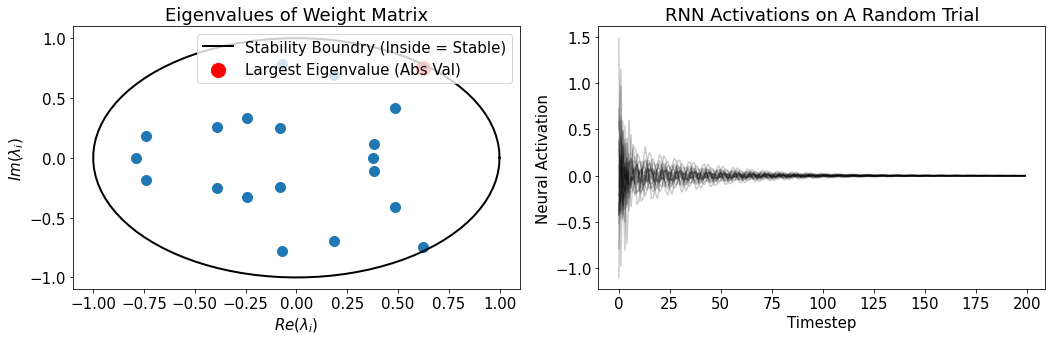

In [53]:
#run linear RNN
states,jacs,W = run_random_vRNN_sim(n = 20,g = .94,T = 200,p = 1000)

#visualize
max_eig = plot_linear_RNN_summary(W,states)

Estimate Jacobian from data and then estimate largest Lyapunov exponent from estimated Jacobian. 

In [54]:
#estimate jacobian from neural activations
js, cs = estimate_jac(states)

#estimate largest eigenvalue from estimated jacobian
estimated_lams = estimate_stability_using_particle(js,1000)

In [55]:

W_eig = np.linalg.eig(W)[0]
js_eig = np.array([np.linalg.eig(js[i])[0] for i in range(js.shape[0])])

Text(0, 0.5, 'Eig est. metric')

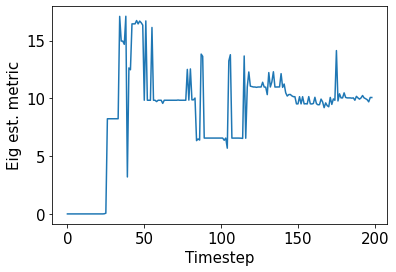

In [56]:
plt.plot(np.abs(js_eig - W_eig).sum(1))
plt.xlabel('Timestep')
plt.ylabel('Eig est. metric')